In [ ]:
"""
@File    : final_report_flora_sun.ipynb
@Create  : 2024/11/04
@Modify  : 2024/11/06
@Author  : Flora Sun
@Contact : flora.y.sun@outlook.com
@Desc    : None
"""

# Import libraries

In [ ]:
import os
import warnings
import importlib

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

# Suppress all warnings
warnings.filterwarnings("ignore")

# Import custom modules
import visualization_function
import calculation_function
import modelling_function

# Reload custom modules
importlib.reload(visualization_function)
importlib.reload(calculation_function)
importlib.reload(modelling_function)

# Import specific functions from custom modules
from visualization_function import (
    plot_tokens_lineplot, 
    plot_tokens_density, 
    plot_tokens_boxplot, 
    plot_token_volatility, 
    plot_splited_date, 
    plot_model_prediction
)

from calculation_function import (
    calculate_token_returns, 
    calculate_volatility
)

from modelling_function import (
    get_modelling_data, 
    RMSE, 
    RMSPE, 
    baseline_mean_model, 
    baseline_random_walk_model, 
    garch_model,
    get_best_pred
)

In [ ]:
cd '/Users/floras/Desktop/okx_project_Nov'

# PART 1: Dataset

In [ ]:
raw_data_path = 'data/raw-data'
raw_data_file = os.listdir(raw_data_path)

## 1.1 - Import token_leanderboard

In [5]:
token_leaderboard = pd.read_csv('data/raw-data/Current Crypto leaderboard.csv')
# Rename columns to lowercase
token_leaderboard.columns = token_leaderboard.columns.str.lower()
# Convert the 'name' column to lowercase
token_leaderboard['name'] = token_leaderboard['name'].str.lower()
print(token_leaderboard.describe())
token_leaderboard

             rank   price (usd)
count  100.000000    100.000000
mean    50.500000    671.722675
std     29.011492   3507.923805
min      1.000000      0.000000
25%     25.750000      0.440350
50%     50.500000      1.841900
75%     75.250000     19.013250
max    100.000000  21311.300000


rank            name symbol   price (usd) market cap vol (24h) total vol  \
0      1         bitcoin    BTC  21311.300000   $407.42B   $32.06B    45.55%   
1      2        ethereum    ETH   1623.220000   $197.86B   $18.54B    26.34%   
2      3          tether   USDT      0.999900    $67.54B   $52.33B    74.35%   
3      4        usd coin   USDC      1.000100    $52.26B    $5.45B     7.74%   
4      5             bnb    BNB    297.300000    $47.87B    $1.46B     2.07%   
..   ...             ...    ...           ...        ...       ...       ...   
95    96            holo    HOT      0.002192   $379.69M   $17.38M     0.02%   
96    97            gala   GALA      0.053380   $371.82M  $203.51M     0.29%   
97    98        compound   COMP     51.150000   $370.50M  $147.90M     0.21%   
98    99            qtum   QTUM      3.474900   $362.55M   $46.50M     0.07%   
99   100  convex finance    CVX      5.350000   $358.00M   $21.67M     0.03%   

   chg (24h) chg (7d)  dataset availability  
0     -0.75%  -11.84%                  True  
1     +0.92%  -14.82%                  True  
2         0%   -0.02%                  True  
3         0%   -0.01%                  True  
4     -0.97%   -7.18%                  True  
..       ...      ...                   ...  
95    -0.74%  -20.37%                  True  
96    -0.21%  -21.03%                  True  
97    +1.55%  -16.76%                  True  
98    +1.01%  -14.93%                  True  
99    +1.52%  -19.65%                  True  

[100 rows x 10 columns]

## 1.2 - Import token price data

In [ ]:
# Get the full data of all tokens
token_data = pd.DataFrame()

# Loop through all token files
for file in raw_data_file:
    if file != 'Current Crypto leaderboard.csv':
        file_path = os.path.join(raw_data_path, file)
        file_data = pd.read_csv(file_path)
        
        # Get the data coverage of each token
        data_start_date, data_end_date = file_data['Date'][0], file_data['Date'][len(file_data)-1]
        print(f'Data coverage: {data_start_date} to {data_end_date} for {file}')
        
        file_data['name'] = file.split('.')[0]
        token_data = pd.concat([token_data, file_data], axis=0)

In [7]:
# Rename the columns into lower cases
token_data.columns = token_data.columns.str.lower()

In [8]:
# Check the data
print(token_data.shape)

(127745, 8)


In [9]:
print(token_data.dtypes)

date         object
open        float64
high        float64
low         float64
close       float64
volume      float64
currency     object
name         object
dtype: object


In [10]:
print(token_data.describe())

                open           high            low          close  \
count  127745.000000  127745.000000  127745.000000  127745.000000   
mean      805.501709     831.308489     777.513005     805.780348   
std      5244.551346    5400.136537    5073.835917    5244.984628   
min         0.000000       0.000000      -6.503000       0.000000   
25%         0.265900       0.279388       0.252100       0.266232   
50%         2.018000       2.127907       1.910020       2.019835   
75%        25.102846      26.345259      23.764202      25.105000   
max     67545.580000   85563.984375   66336.200000   67545.580000   

             volume  
count  1.277450e+05  
mean   3.216540e+08  
std    2.451828e+09  
min    0.000000e+00  
25%    1.653093e+06  
50%    2.141148e+07  
75%    1.648505e+08  
max    6.131225e+11  


In [11]:
# Reset the index of the full_token_data
token_data = token_data.reset_index(drop=True)
# Convert the 'name' column to lowercase
token_data['name'] = token_data['name'].str.lower()
# Convert the 'Date' column to datetime
token_data['date'] = pd.to_datetime(token_data['date'])

## 1.3 - Merge the token leaderboard with the full token data to get token symbol

In [12]:
# Merge the token symbol with the token leaderboard
token_data_full = token_data.merge(token_leaderboard[['name', 'symbol']], on='name', how='left')

# Check the missing values
token_data_full[token_data_full['symbol'].isnull()]['name'].unique()

array([], dtype=object)

In [13]:
# print full_token_data length
print('token_data_full length:', len(token_data_full))
# print full_token_data head
display(token_data_full.head())
# print full_token_data tail
display(token_data_full.tail())

token_data_full length: 127745


date      open      high       low     close   volume currency  \
0 2018-05-03  0.218809  0.218809  0.218809  0.218809  13091.0      USD   
1 2018-10-02  0.053027  0.059164  0.052307  0.058936   6092.0      USD   
2 2018-10-03  0.058959  0.058959  0.052809  0.056992    669.0      USD   
3 2018-10-04  0.057001  0.058293  0.052239  0.052239    420.0      USD   
4 2018-10-05  0.052228  0.059093  0.052228  0.059093  16443.0      USD   

      name symbol  
0  celsius    CEL  
1  celsius    CEL  
2  celsius    CEL  
3  celsius    CEL  
4  celsius    CEL

date   open   high    low  close     volume currency       name  \
127740 2022-08-19  24.20  24.38  21.40  22.45  4153492.0      USD  avalanche   
127741 2022-08-20  22.44  23.07  21.63  22.29  2538956.0      USD  avalanche   
127742 2022-08-21  22.30  23.43  22.17  22.95  2346995.0      USD  avalanche   
127743 2022-08-22  22.99  22.99  21.64  22.57  2133496.0      USD  avalanche   
127744 2022-08-23  22.58  22.89  22.48  22.79  2168362.0      USD  avalanche   

       symbol  
127740   AVAX  
127741   AVAX  
127742   AVAX  
127743   AVAX  
127744   AVAX

## 1.4 - Calculate daily_return, log_return for each token

In [14]:
# Apply the function to each token group
token_data_full = token_data_full.groupby('name').apply(calculate_token_returns)
# Check daily return statistics
display(token_data_full['daily_return'].describe())
# Display the DataFrame with new columns
token_data_full.head()

count    1.270640e+05
mean              inf
std               NaN
min     -1.000000e+00
25%     -2.692515e-02
50%      0.000000e+00
75%      2.728444e-02
max               inf
Name: daily_return, dtype: float64

date      open      high       low     close   volume currency  \
0 2018-05-03  0.218809  0.218809  0.218809  0.218809  13091.0      USD   
1 2018-10-02  0.053027  0.059164  0.052307  0.058936   6092.0      USD   
2 2018-10-03  0.058959  0.058959  0.052809  0.056992    669.0      USD   
3 2018-10-04  0.057001  0.058293  0.052239  0.052239    420.0      USD   
4 2018-10-05  0.052228  0.059093  0.052228  0.059093  16443.0      USD   

      name symbol  daily_return  log_return  
0  celsius    CEL           NaN         NaN  
1  celsius    CEL     -0.730651   -1.311747  
2  celsius    CEL     -0.032985   -0.033541  
3  celsius    CEL     -0.083398   -0.087082  
4  celsius    CEL      0.131205    0.123283

### ✨ Drop token with extremely high daily return

When a token has an extremely high daily return, it can significantly affect the analysis of the overall dataset by skewing the results and providing a misleading picture of the average performance: 
- Mean Distortion: These extreme values can inflate the mean, making it seem like the typical return is higher than it actually is for most tokens. 
- Volatility Misrepresentation: High returns may also increase the perceived volatility, affecting risk assessments and strategies based on the data. 
- Misleading Visualizations: In plots, these tokens can dominate the scale, making it hard to see the variations and patterns of other tokens.

As such, we will remove tokens with extreme returns

In [15]:
# drop data of tokens with inf daily return 
inf_return_tokens = token_data_full[(token_data_full['daily_return'] == np.inf) | (token_data_full['daily_return'] >= 10)]['name'].unique()
print('Tokens with inf daily return:', inf_return_tokens)
token_data_full = token_data_full[~token_data_full['name'].isin(inf_return_tokens)]

Tokens with inf daily return: ['compound' 'aave' 'dogecoin' 'shiba inu' 'apecoin']


## 1.5 - Calculate daily volatility and annualized volatility

We used log returns $ \ r_t = \log\left(\frac{S_t}{S_{t-1}}\right)\ $ to calculate volatility. For practicality purposes, it's generally preferable to use log returns, especially in mathematical modeling, because it helps eliminate non-stationary properties of time series data and makes it more stable. Log return is also additive across time: $ \ r_{t1,t2} + r_{t2,t3} = r_{t1,t3} \ $, which is another advantage of using it.

In [16]:
# Apply the function to each token group
token_data_full = token_data_full.groupby("name").apply(calculate_volatility, interval_lst = [7, 30, 90, 180, 365])
# Display the DataFrame with new columns
token_data_full.tail()

date   open   high    low  close     volume currency       name  \
127740 2022-08-19  24.20  24.38  21.40  22.45  4153492.0      USD  avalanche   
127741 2022-08-20  22.44  23.07  21.63  22.29  2538956.0      USD  avalanche   
127742 2022-08-21  22.30  23.43  22.17  22.95  2346995.0      USD  avalanche   
127743 2022-08-22  22.99  22.99  21.64  22.57  2133496.0      USD  avalanche   
127744 2022-08-23  22.58  22.89  22.48  22.79  2168362.0      USD  avalanche   

       symbol  daily_return  ...  daily_volatility_7  annualized_volatility_7  \
127740   AVAX     -0.071931  ...            0.024667                 0.471257   
127741   AVAX     -0.007127  ...            0.024461                 0.467325   
127742   AVAX      0.029610  ...            0.035341                 0.675189   
127743   AVAX     -0.016558  ...            0.034914                 0.667024   
127744   AVAX      0.009747  ...            0.037925                 0.724549   

        daily_volatility_30  annualized_volatility_30  daily_volatility_90  \
127740             0.049821                  0.951825             0.065653   
127741             0.048493                  0.926463             0.065315   
127742             0.047827                  0.913727             0.064789   
127743             0.047923                  0.915564             0.064810   
127744             0.047929                  0.915677             0.064478   

        annualized_volatility_90  daily_volatility_180  \
127740                  1.254302              0.065022   
127741                  1.247848              0.064669   
127742                  1.237784              0.064518   
127743                  1.238195              0.064521   
127744                  1.231853              0.064437   

        annualized_volatility_180  daily_volatility_365  \
127740                   1.242242              0.071844   
127741                   1.235492              0.070403   
127742                   1.232622              0.070133   
127743                   1.232671              0.070138   
127744                   1.231076              0.070053   

        annualized_volatility_365  
127740                   1.372571  
127741                   1.345052  
127742                   1.339884  
127743                   1.339980  
127744                   1.338370  

[5 rows x 21 columns]

# PART 2: Data Visualization and Summary Statistics

In this section, we first classify tokens into different groups based on their all-time highs. Then, we'll analyze token **price trends**, **log-returns**, and **annulized volatility** to understand the general patterns in the data

## 2.1 - Clasify tokens into different groups based on their all-time high

We classify tokens into different tiers based on their all-time high (ATH) because tokens with similar ATHs tend to have prices in the same range. 

This classification prevents the issue of some tokens' patterns being compressed heavily, which can obscure important trends and insights. By aligning tokens with similar price ranges, our visualizations become more effective, enabling easier comparison and analysis of their performance over time.

In [17]:
token_ath = token_data_full.groupby('name')['high'].max().reset_index()
token_ath.columns = ['name', 'ath']
token_ath['rank'] = token_ath['ath'].rank(ascending=False)
token_ath = token_ath.sort_values('rank')
display(token_ath.head())
display(token_ath.tail())

name           ath  rank
8      bitcoin bep2  85563.984375   1.0
89  wrapped bitcoin  69026.910000   2.0
7           bitcoin  68990.600000   3.0
53            maker   6339.024414   4.0
31         ethereum   4864.060000   5.0

name       ath  rank
87           vechain  0.278216  89.0
92           zilliqa  0.256293  90.0
80              tron  0.229112  91.0
12  bittorrent (new)  0.014265  92.0
27             ecash  0.005112  93.0

### 💡 Observation: Bitcoin's High Price
- Bitcoin's all-time high (ATH) is significantly higher than that of other tokens, highlighting its unique position in the cryptocurrency market. 
- Due to its substantial influence and distinctive market behavior, it is beneficial to analyze Bitcoin separately.

In [18]:
# Each tier has 10 tokens
rank_tier = [(1,4)] + [(k, k+10) for k in range(4, 94, 10)]
# Get the tokens in each tier
tier_token_name_dict = {}
for i in range(len(rank_tier)):
    start_rank, end_rank = rank_tier[i][0], rank_tier[i][1]
    tier_tokens = token_ath[(token_ath['rank'] >= start_rank) & (token_ath['rank'] < end_rank)]['name'].values.tolist()
    tier_token_name_dict[i+1] = tier_tokens

## 2.2 - Token Price Trends

### 2.2.1 - Visualization by tiers

Tier 1 tokens: ['bitcoin bep2', 'wrapped bitcoin', 'bitcoin']


Tier 2 tokens: ['maker', 'ethereum', 'bitcoin cash', 'pax gold', 'dash', 'gnosis', 'zcash', 'internet computer', 'bnb', 'kusama']


Tier 3 tokens: ['elrond', 'monero', 'bitcoin gold', 'bitcoin sv', 'quant', 'litecoin', 'decred', 'filecoin', 'neo', 'ethereum classic']


Tier 4 tokens: ['tether', 'axie infinity', 'avalanche', 'stepn', 'qtum', 'solana', 'arweave', 'ftx token', 'convex finance', 'waves']


Tier 5 tokens: ['curve dao token', 'helium', 'polkadot', 'chainlink', 'the graph', 'flow', 'uniswap', 'pancakeswap', 'okb', 'huobi token']


Tier 6 tokens: ['cosmos', 'kucoin token', 'synthetix', 'eos', 'thorchain', 'near protocol', 'lido dao', 'theta network', 'tezos', 'celo']


Tier 7 tokens: ['mina', 'kava', 'the sandbox', 'unus sed leo', 'celsius', '1inch', 'decentraland', 'iota', 'enjin coin', 'nexo']


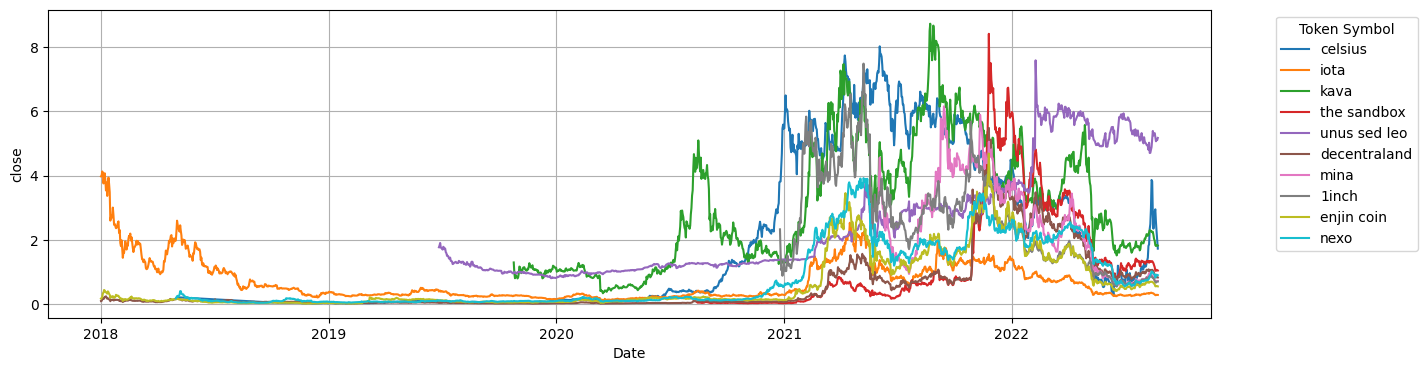

Tier 8 tokens: ['klaytn', 'loopring', 'stacks', 'fantom', 'xrp', 'algorand', 'cardano', 'polygon', 'fei usd', 'dai']


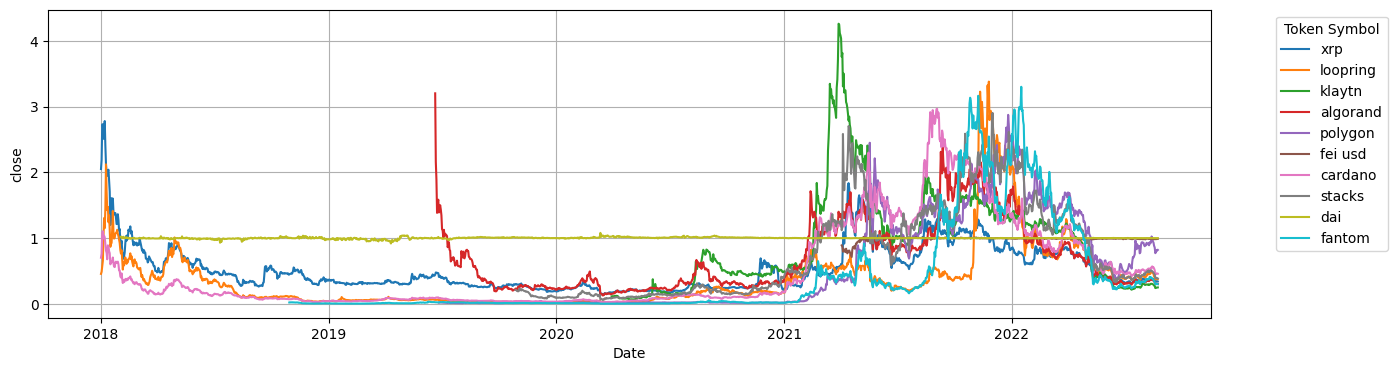

Tier 9 tokens: ['nem', 'pax dollar', 'basic attention token', 'trust wallet token', 'trueusd', 'neutrino usd', 'binance usd', 'usd coin', 'usdd', 'cronos']


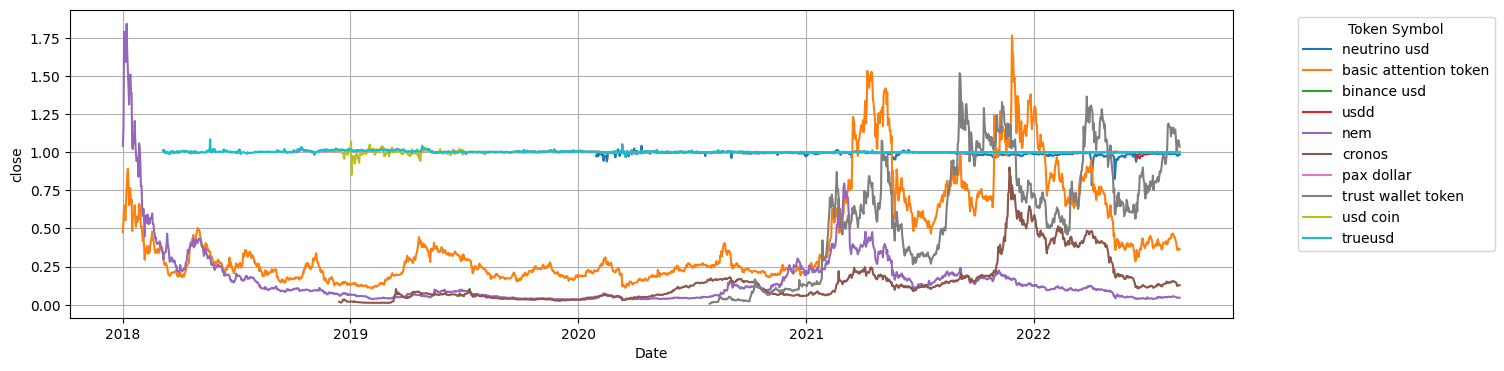

Tier 10 tokens: ['stellar', 'chiliz', 'gala', 'hedera', 'holo', 'vechain', 'zilliqa', 'tron', 'bittorrent (new)', 'ecash']


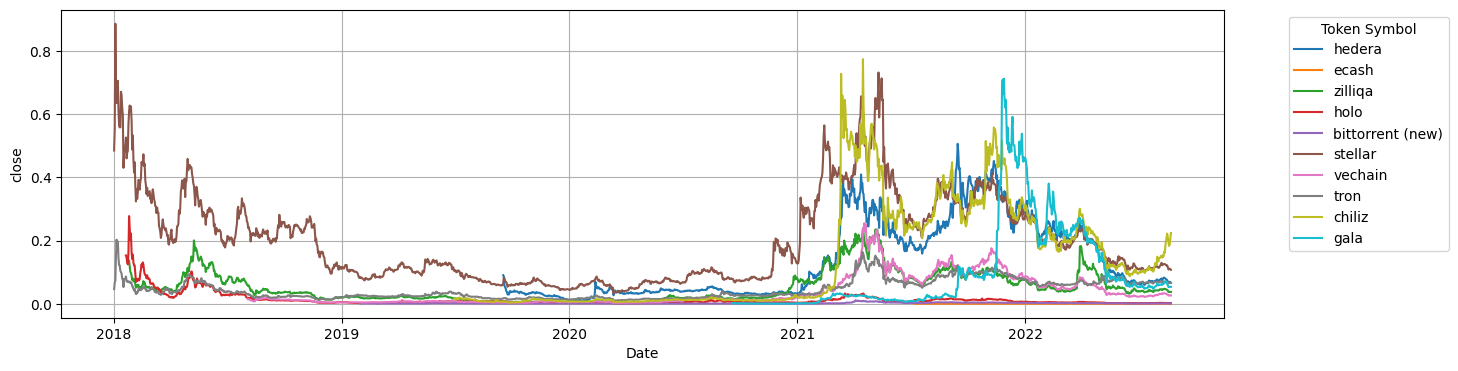

In [19]:
# Plot the tokens in each tier
for tier in range(1, 11):
    tokens = tier_token_name_dict[tier]
    print(f'Tier {tier} tokens:', tokens)
    plot_tokens_lineplot(token_data_full, tokens, start_date='2018-01-01', metric='close')

### 💡 Observation: Overall Price Trends
- Tokens with similar all-time highs (ATHs) often have prices within the same range. Classifying tokens by their ATH helps us clearly observe their price trends.
- Most cryptocurrencies experienced significant peaks around early 2018 and again during the 2020-2021 bull run.
- Stablecoins like USD Coin and Binance USD maintained relatively stable prices, reflecting their role as stable assets.

## 2.3 - Token Log-Return

### 2.3.1 - Visualization by tiers

Tier 1 tokens: ['bitcoin bep2', 'wrapped bitcoin', 'bitcoin']


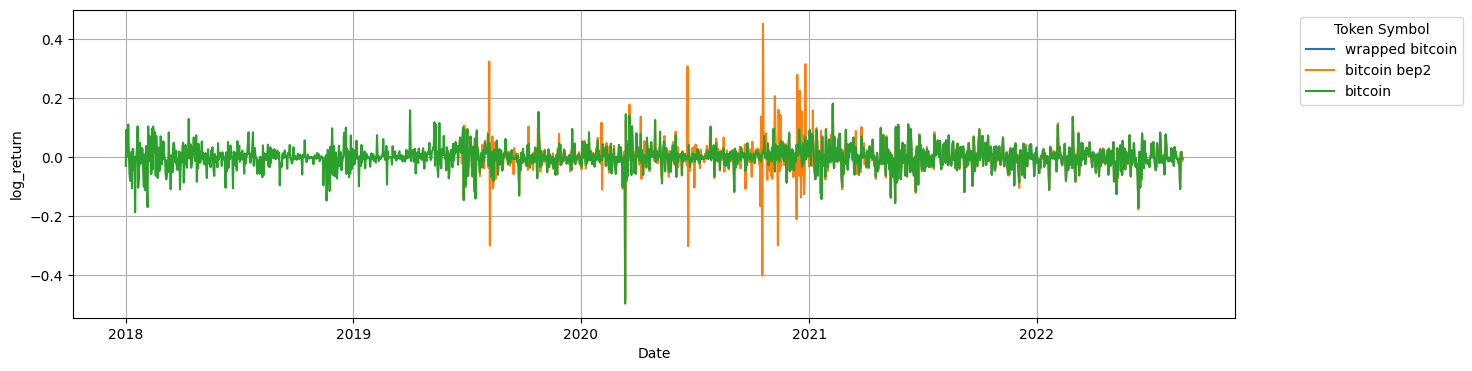

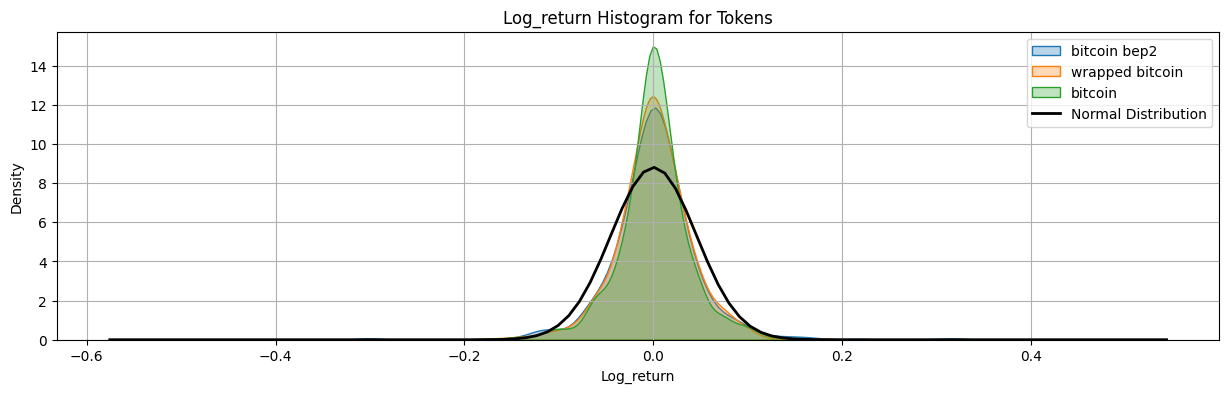

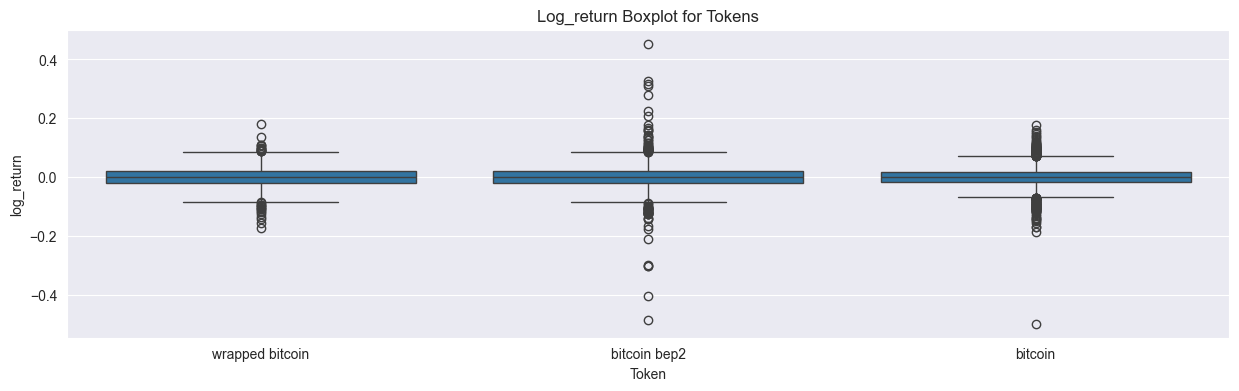

Tier 2 tokens: ['maker', 'ethereum', 'bitcoin cash', 'pax gold', 'dash', 'gnosis', 'zcash', 'internet computer', 'bnb', 'kusama']


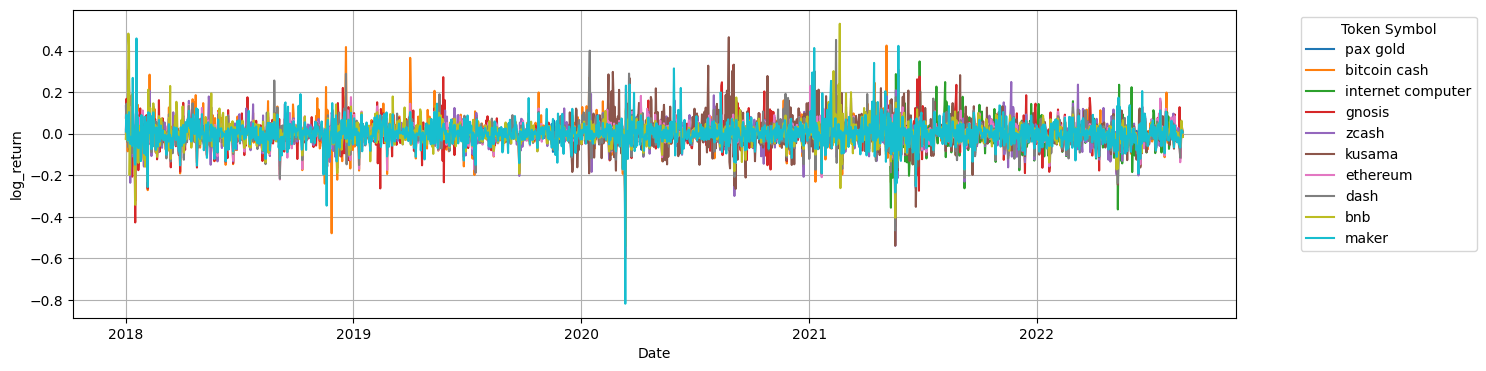

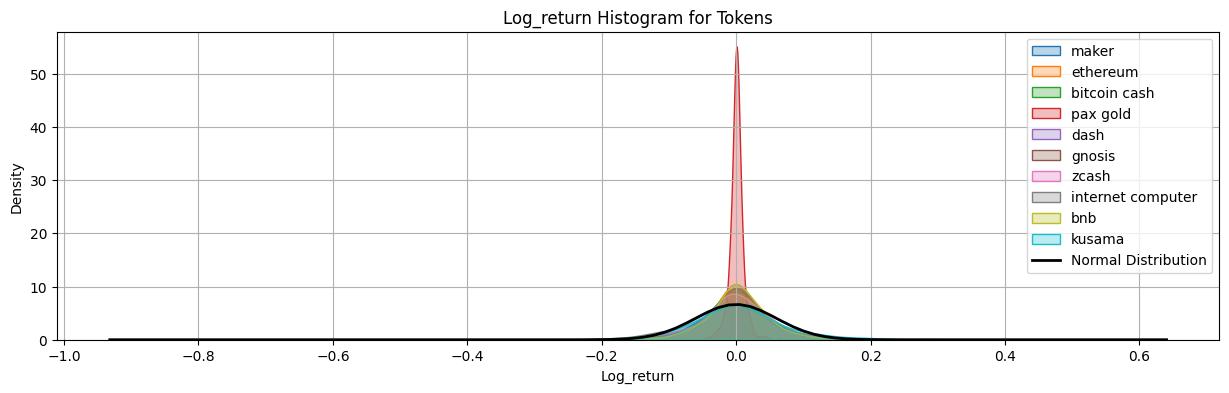

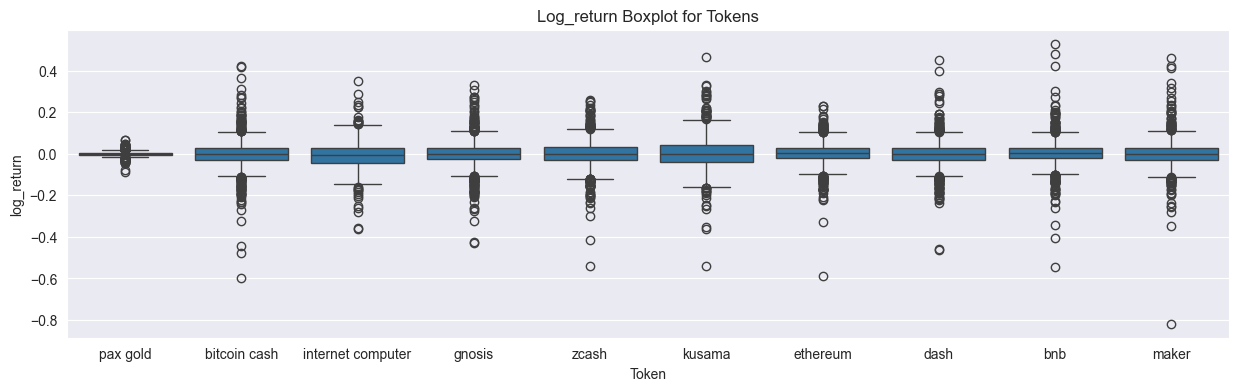

Tier 3 tokens: ['elrond', 'monero', 'bitcoin gold', 'bitcoin sv', 'quant', 'litecoin', 'decred', 'filecoin', 'neo', 'ethereum classic']


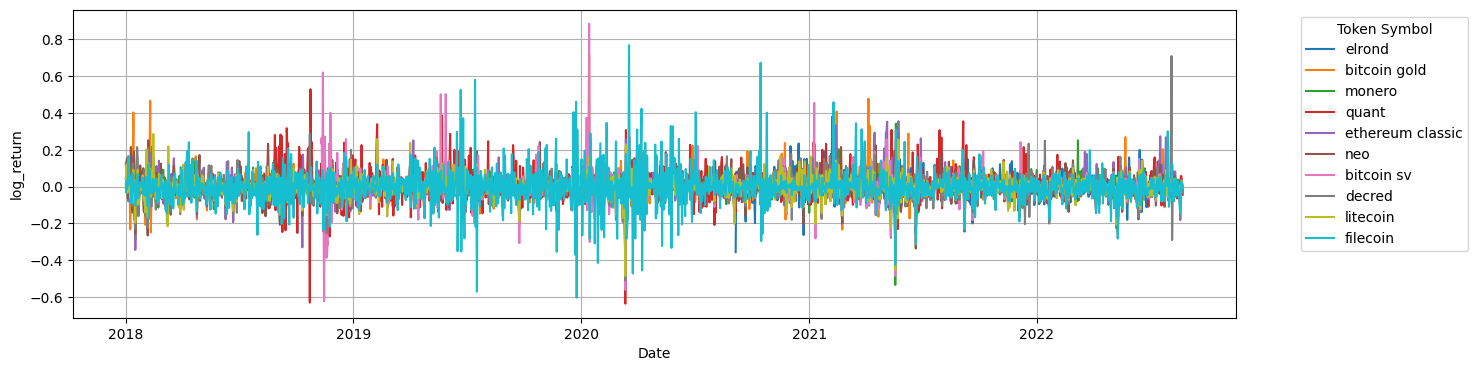

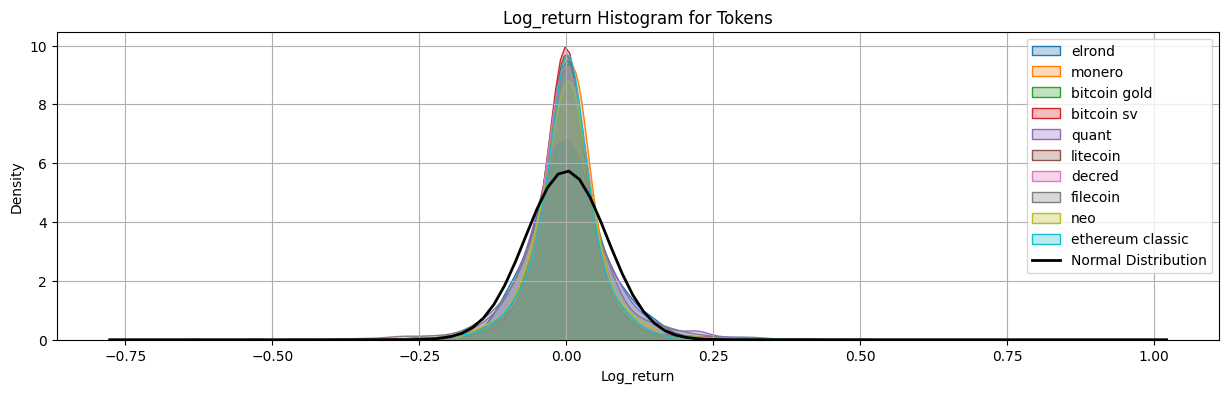

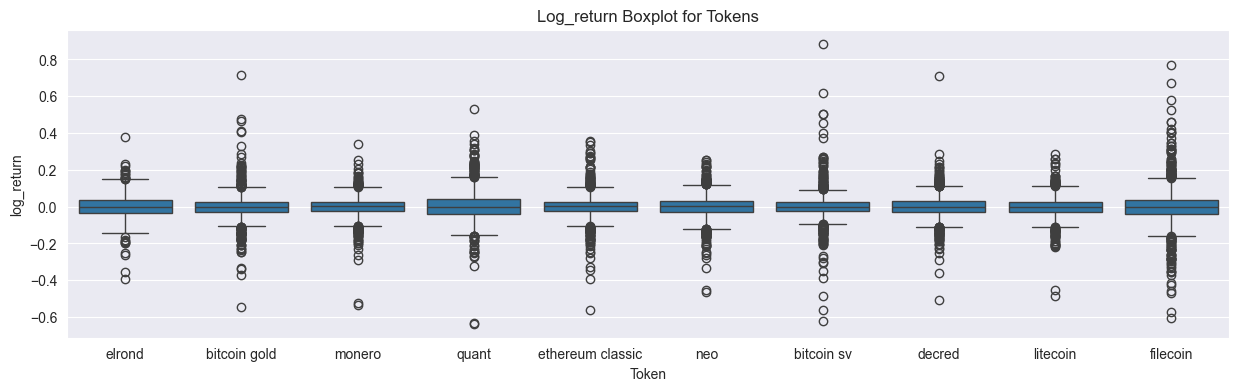

Tier 4 tokens: ['tether', 'axie infinity', 'avalanche', 'stepn', 'qtum', 'solana', 'arweave', 'ftx token', 'convex finance', 'waves']


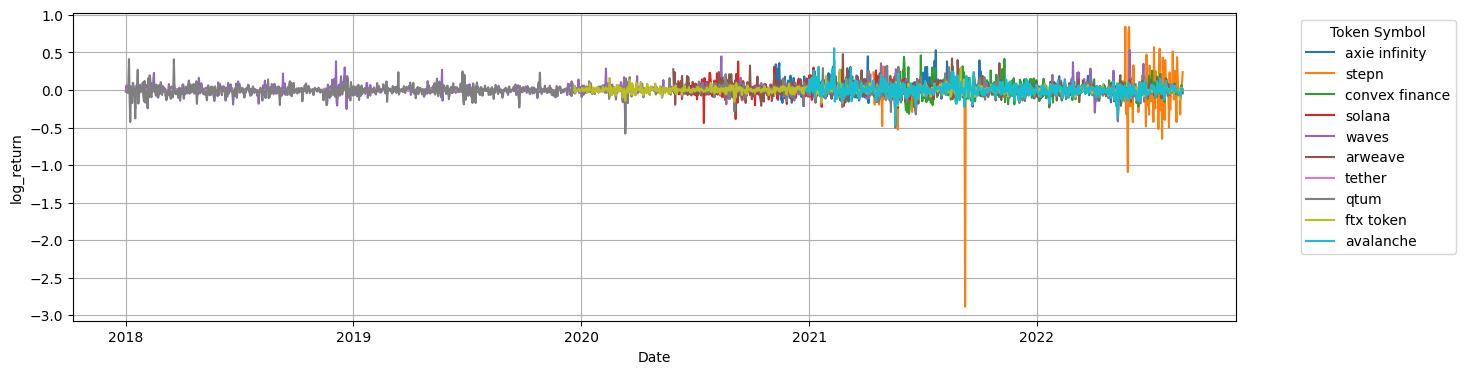

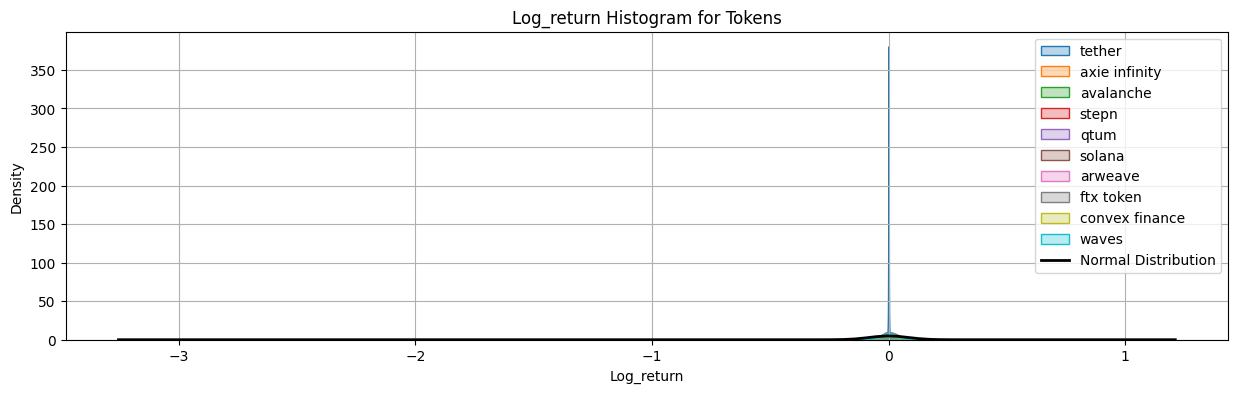

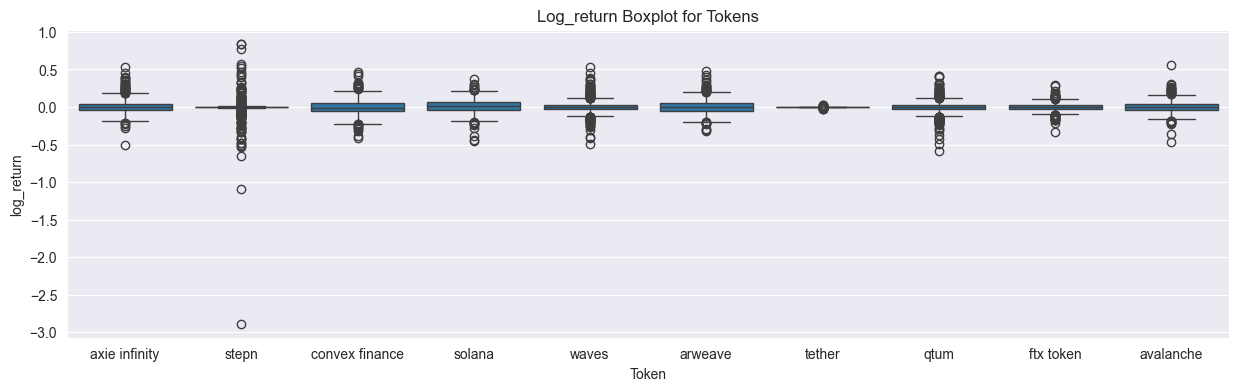

Tier 5 tokens: ['curve dao token', 'helium', 'polkadot', 'chainlink', 'the graph', 'flow', 'uniswap', 'pancakeswap', 'okb', 'huobi token']


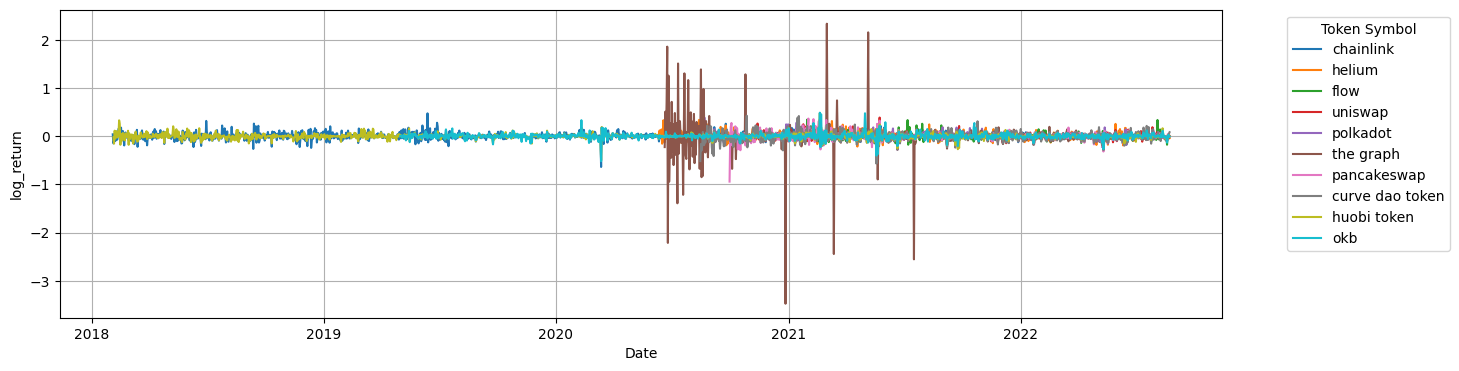

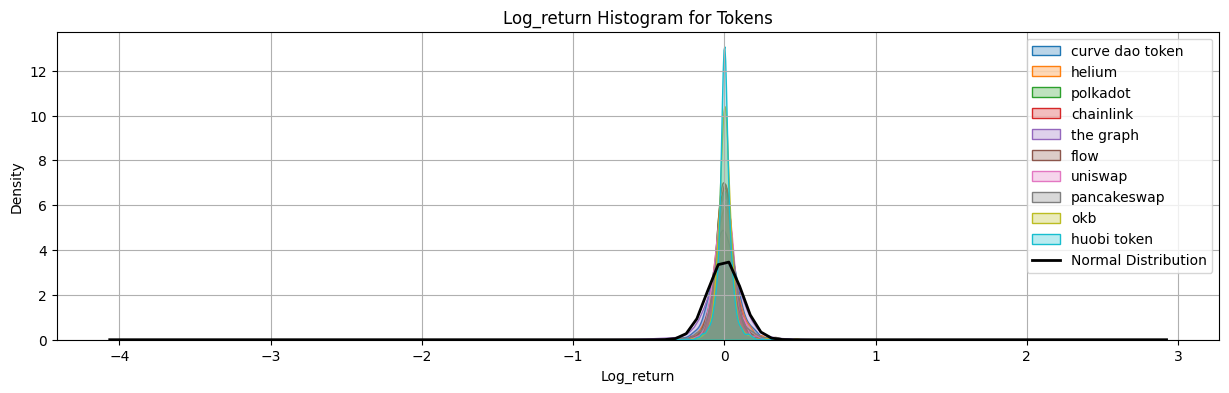

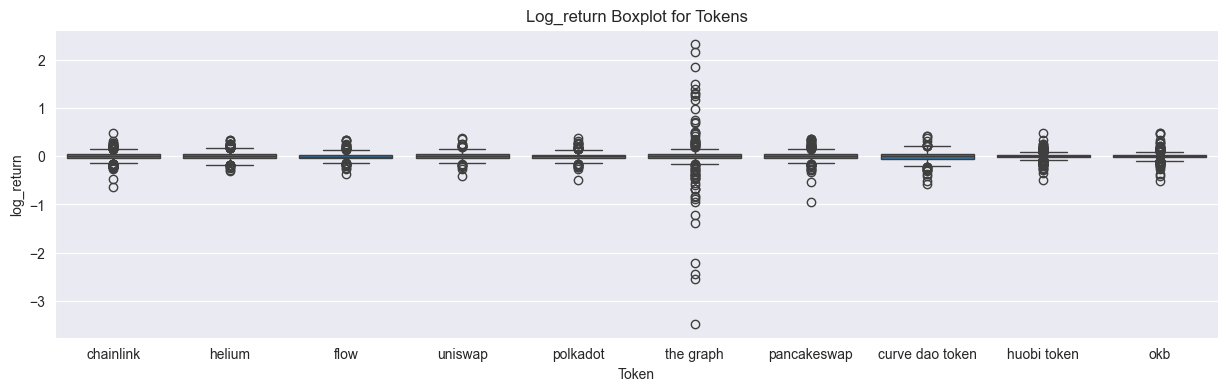

Tier 6 tokens: ['cosmos', 'kucoin token', 'synthetix', 'eos', 'thorchain', 'near protocol', 'lido dao', 'theta network', 'tezos', 'celo']


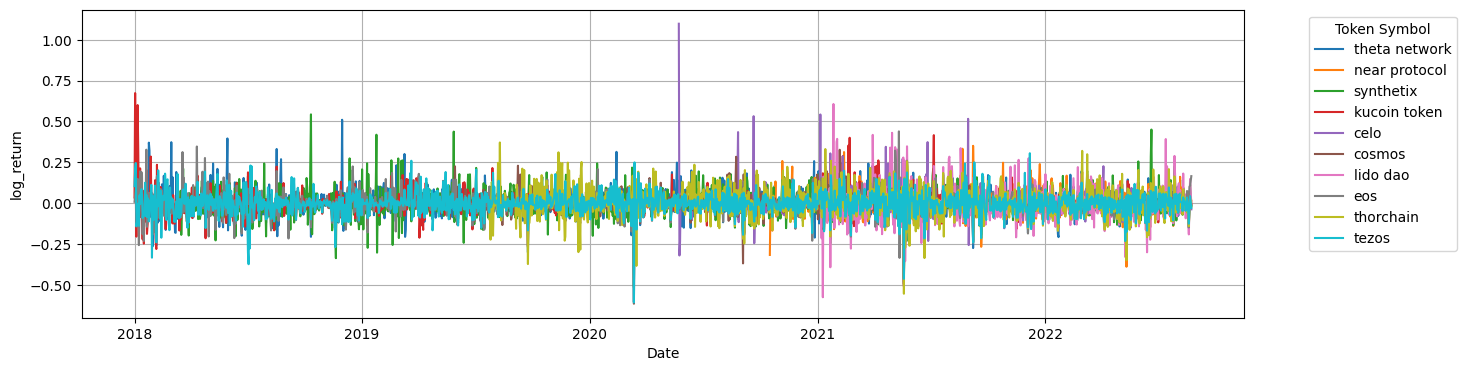

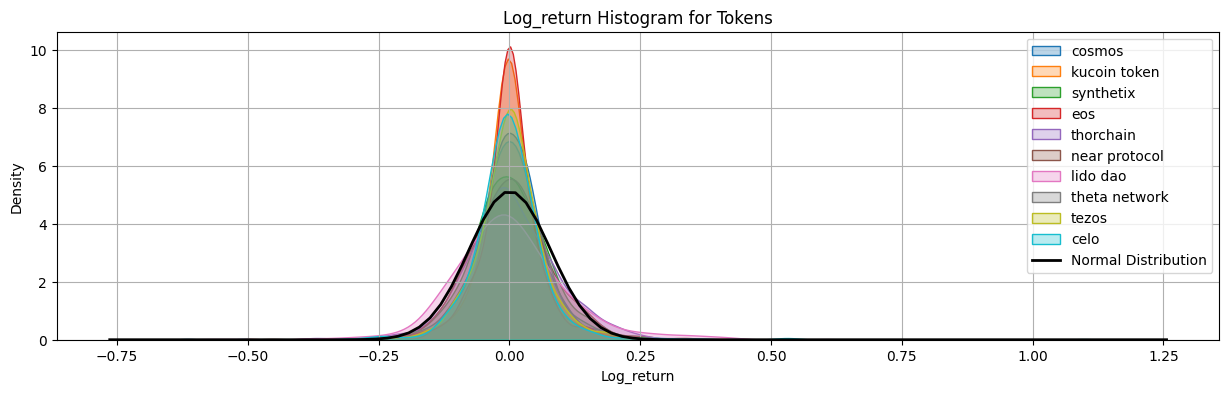

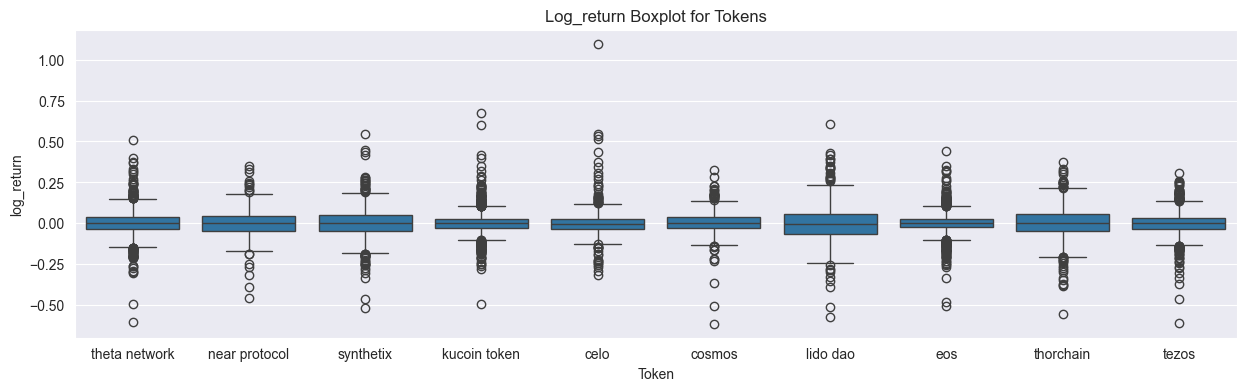

Tier 7 tokens: ['mina', 'kava', 'the sandbox', 'unus sed leo', 'celsius', '1inch', 'decentraland', 'iota', 'enjin coin', 'nexo']


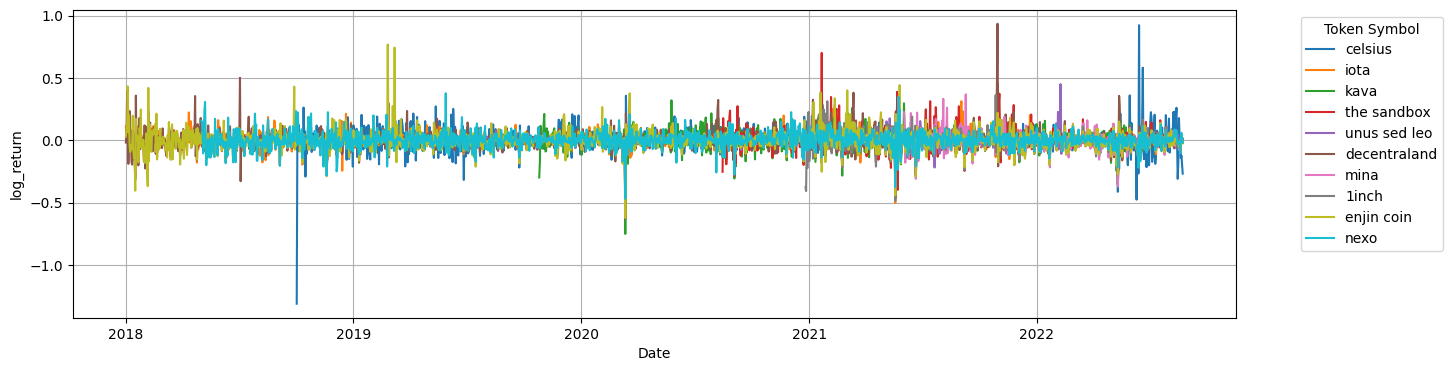

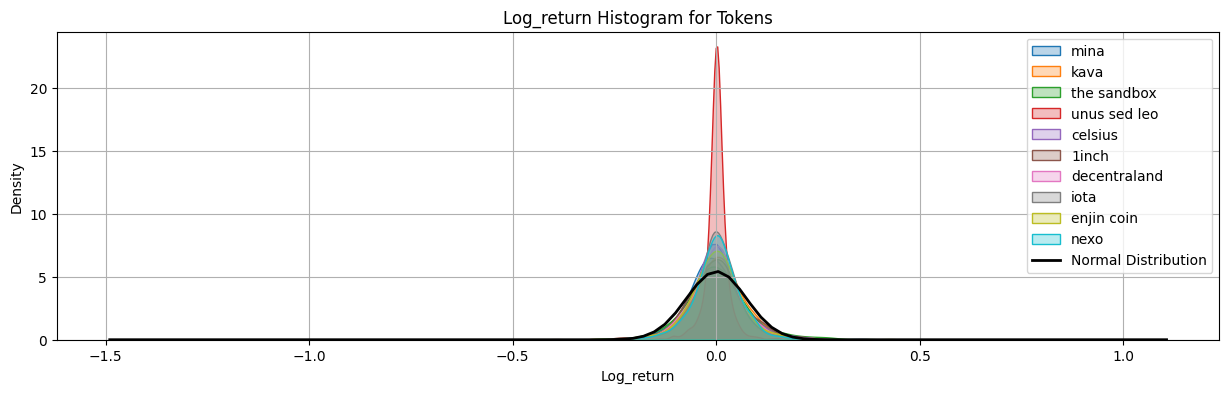

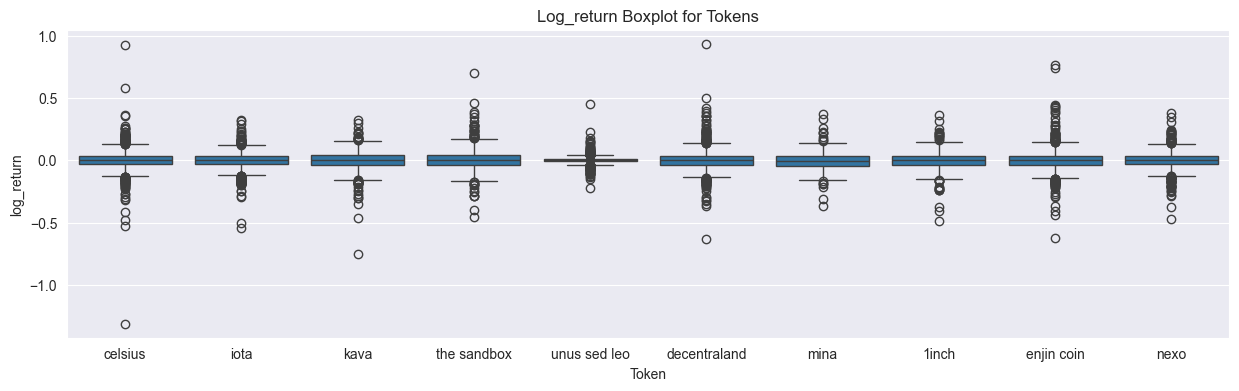

Tier 8 tokens: ['klaytn', 'loopring', 'stacks', 'fantom', 'xrp', 'algorand', 'cardano', 'polygon', 'fei usd', 'dai']


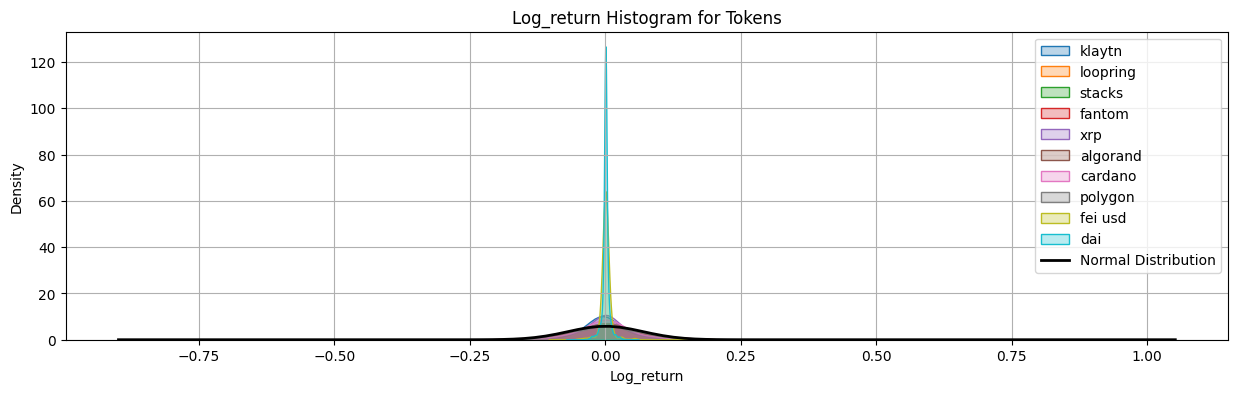

Tier 9 tokens: ['nem', 'pax dollar', 'basic attention token', 'trust wallet token', 'trueusd', 'neutrino usd', 'binance usd', 'usd coin', 'usdd', 'cronos']


Tier 10 tokens: ['stellar', 'chiliz', 'gala', 'hedera', 'holo', 'vechain', 'zilliqa', 'tron', 'bittorrent (new)', 'ecash']


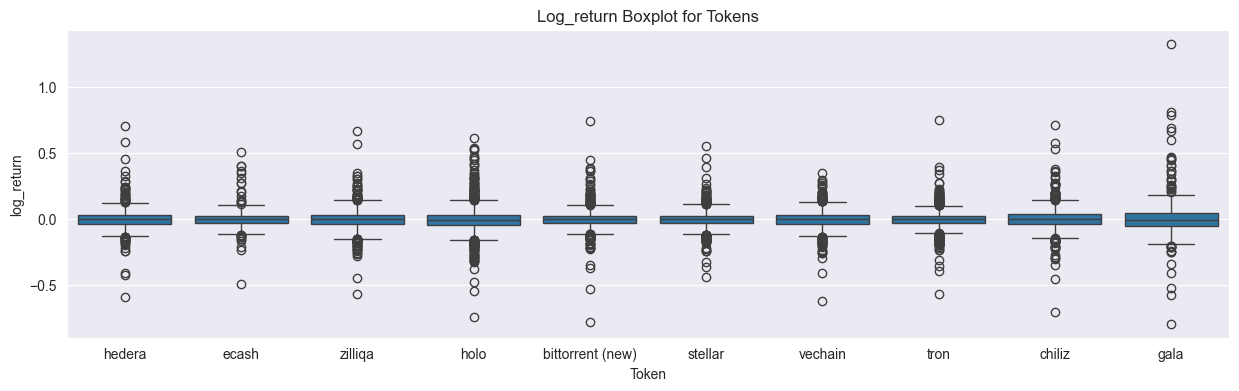

In [20]:
# Plot the tokens daily return in each tier - line chart
for tier in range(1, 3):
    tokens = tier_token_name_dict[tier]
    print(f"Tier {tier} tokens:", tokens)
    plot_tokens_lineplot(token_data_full, tokens, start_date='2018-01-01', metric='log_return')
    plot_tokens_density(token_data_full, tokens, start_date='2018-01-01', metric='log_return')
    plot_tokens_boxplot(token_data_full, tokens, start_date='2018-01-01', metric='log_return')

### 2.3.2 - Check the stationarity of the time series

GARCH Model Requires 
The **Augmented Dickey-Fuller test** is used to test for stationarity in a time series. If the series is stationary, it doesn't have a unit root, indicating stability in the mean and variance over time. We check stationarity for all tokens.

In [21]:
# LOG RETURNS
stationary_check_results = []
for token in token_data_full['name'].unique():
    df = token_data_full[token_data_full['name'] == token]
    adfuller_results = adfuller(df['log_return'].dropna())
    adf = adfuller_results[0]
    p_value = adfuller_results[1]
    stationary_check_results.append([token, adf, p_value])

stationary_check_df = pd.DataFrame(stationary_check_results, columns=['name', 'adf', 'p_value'])
stationary_check_df['stationary'] = stationary_check_df['p_value'] < 0.05

In [22]:
display(stationary_check_df['stationary'].value_counts())

True    93
Name: stationary, dtype: int64

In [23]:
stationary_check_df.sort_values('p_value')

name        adf       p_value  stationary
46               nem -24.136257  0.000000e+00        True
26              holo -20.035589  0.000000e+00        True
27  bittorrent (new) -37.400590  0.000000e+00        True
79       huobi token -19.095948  0.000000e+00        True
31             quant -27.306183  0.000000e+00        True
..               ...        ...           ...         ...
54       pancakeswap  -6.716372  3.573493e-09        True
84              tron  -6.624538  5.921598e-09        True
55              mina  -6.283568  3.745146e-08        True
68           fei usd  -6.054815  1.252495e-07        True
43              usdd  -3.104548  2.621846e-02        True

[93 rows x 4 columns]

### 💡 Observation: Log-return across different tiers

- We focused on analyzing **log_returns** (instead of daily_returns) for subsequent analysis. Log returns help eliminate the non-stationary properties of time series data, making it more stable and additive over time.
- Log-returns for all tokens fluctuate around zero. In other words, all tokens have **Zero Mean of Returns**
- Higher-tier tokens like Bitcoin and Ethereum exhibit more consistent and moderate returns.
- Lower-tier tokens show greater volatility and display heavier tails, indicating occasional large price swings.
- Stablecoins like USD Coin and Tether maintain stable returns close to zero, reflecting their purpose of stability.
- Using a significant level alpha of 0.05, p-value for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis --> **Log-returns are not dependent on time/trend (stationarity)**

## 2.4 - Token Volatility

We can plot volatility for different tokens by changing the first parameter in the function below. Token name can be found in "tier_token_name_dict"

In [24]:
# tier_token_name_dict

In [25]:
plot_token_volatility('nem', token_data_full, start_date='2018-01-01')

### 💡 Observation: Volatility clustering,  30-day Interval

I checked for multiple tokens from different tiers and I found that for most tokens:

- **Volatility clusters**, meaning that large changes in returns are likely to be followed by large changes, and small changes by small changes
- Using shorter interval (e.g., 7 days) seems too noisy to observe meaningful patterns
- Using longer intervals (e.g., 90 days) seem to smooth the volatility down significantly. It can also lead to wasting too many datapoints at the beginning of the dataset
- Using an interval window of 30 days seems to be a good option. It's equivalent to roughly 1 month of trading for cryptocurrencies.

# PART 3: Method

## 3.1 - Train-Validation-Test Split

I would split the datapoints for all tokens into 3 parts as follows:

- The most recent **5%** usable datapoints would be used for **Final Model Testing**
- The first **80%** datapoints would be used for **Training**
- The rest **15%** datapoints in the middle would be used for **Validation and Model Tuning during training**

## 3.2 - Evaluating Performance Metric

We use **Root Mean Squared Percentage Error (RMSPE)** and **Root Mean Square Errors (RMSE)** to measure the performance of different models.

RMSPE provides a way to measure the relative prediction accuracy of a forecasting model, making it useful for comparing models with different scales. It is expressed as a percentage and is calculated using the following formula:

$$
\text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2} \times 100
$$

- $y_i$ is the actual value.
- $\hat{y}_i$ is the predicted value.
- $n$ is the number of observations.



RMSE is a popular metric that's used for quantifing the average magnitude of forecast errors in a model's predictions. The formula for RMSE is given by:

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

where $y_i$ are the observed values and $\hat{y}_i$ are the predicted values.

## 3.3 - Modelling

I'll use an interval window of `30` days to calculate `daily_volatility` for each token on each day (30 days after its first datapoint), and then forecast the `daily_volatility` of the next `7` days using all previous available datapoint on a rolling basis. We can obtain `annualized_volatility`  by multiplying `daily_volatility` with $\sqrt{365}$

Models that I will use include: 
1. Baseline Mean Model
2. Baseline Random Walk Naive Forecasting Model
3. Basic Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Model
4. Glosten-Jagannathan-Runkle GARCH (GJR-GARCH)
5. Exponential GARCH (EGARCH)
6. Threshold ARCH (TARCH)

Models 1 and 2 serve as baseline comparisons, representing potential predictions without mathematical forecasting methods.

Models 3, 4, 5, and 6 are part of the GARCH model family, which is widely used for modeling volatility. 

GARCH models (including variants) do not assume that future volatility will mirror the past. GARCH models can effectively capture **volatility clustering**, where tomorrow's volatility tends to be similar to today's, and **mean reversion**, where long-term volatility reverts to the historical average. These patterns were observed in the previous section.

## 3.4 - Prediction

For Models 3-6, we will implement the **Expanding Window Approach** for prediction. This involves refitting the model to **ALL** available data up to a certain time step before generating predictions for the next `7` days. For instance, to predict annualized_volatility at time step `t`, the model will be fitted with all returns available up to `t`, and then the average forecasted volatility for a horizon of `7` days will be obtained.

# PART 4: Implimentation

In [26]:
# We will model for all tokens, but we select one token for demonstration
example_token = "wrapped bitcoin"

## 4.1 - Geneate target annulized return (using 30-day interval)

In [27]:
future_horizon = 7

In [28]:
token_data_full["daily_volatility_30_target"] = token_data_full.groupby("name")[
    "daily_volatility_30"
].shift(-future_horizon)
token_data_full["annualized_volatility_30_target"] = token_data_full.groupby("name")[
    "annualized_volatility_30"
].shift(-future_horizon)
token_data_full.tail()

date   open   high    low  close     volume currency       name  \
127740 2022-08-19  24.20  24.38  21.40  22.45  4153492.0      USD  avalanche   
127741 2022-08-20  22.44  23.07  21.63  22.29  2538956.0      USD  avalanche   
127742 2022-08-21  22.30  23.43  22.17  22.95  2346995.0      USD  avalanche   
127743 2022-08-22  22.99  22.99  21.64  22.57  2133496.0      USD  avalanche   
127744 2022-08-23  22.58  22.89  22.48  22.79  2168362.0      USD  avalanche   

       symbol  daily_return  ...  daily_volatility_30  \
127740   AVAX     -0.071931  ...             0.049821   
127741   AVAX     -0.007127  ...             0.048493   
127742   AVAX      0.029610  ...             0.047827   
127743   AVAX     -0.016558  ...             0.047923   
127744   AVAX      0.009747  ...             0.047929   

        annualized_volatility_30  daily_volatility_90  \
127740                  0.951825             0.065653   
127741                  0.926463             0.065315   
127742                  0.913727             0.064789   
127743                  0.915564             0.064810   
127744                  0.915677             0.064478   

        annualized_volatility_90  daily_volatility_180  \
127740                  1.254302              0.065022   
127741                  1.247848              0.064669   
127742                  1.237784              0.064518   
127743                  1.238195              0.064521   
127744                  1.231853              0.064437   

        annualized_volatility_180  daily_volatility_365  \
127740                   1.242242              0.071844   
127741                   1.235492              0.070403   
127742                   1.232622              0.070133   
127743                   1.232671              0.070138   
127744                   1.231076              0.070053   

        annualized_volatility_365  daily_volatility_30_target  \
127740                   1.372571                         NaN   
127741                   1.345052                         NaN   
127742                   1.339884                         NaN   
127743                   1.339980                         NaN   
127744                   1.338370                         NaN   

        annualized_volatility_30_target  
127740                              NaN  
127741                              NaN  
127742                              NaN  
127743                              NaN  
127744                              NaN  

[5 rows x 23 columns]

In [29]:
# Geneate a new dataframe for modelling
model_data_full = token_data_full.copy()
# Drop the columns that are not needed for modelling
model_data_full = model_data_full.drop(
    columns=[
        "open",
        "high",
        "low",
        "volume",
        "daily_volatility_7",
        "daily_volatility_90",
        "daily_volatility_180",
        "daily_volatility_365",
        "annualized_volatility_7",
        "annualized_volatility_90",
        "annualized_volatility_180",
        "annualized_volatility_365",
    ]
)
# Drop the rows with missing values
model_data_full = model_data_full.dropna()

## 4.2 - Train-Test-Validation

### 4.2.1 - Split and store data sets

In [30]:
# For each token, get the modelling data
modelling_data_dict_full = {}
for token in model_data_full["name"].unique():
    (
        token_df,
        target_train,
        target_validation,
        target_test,
        vol_train,
        vol_validation,
        vol_test,
        lr_train,
        lr_validation,
        lr_test,
    ) = get_modelling_data(token, model_data_full)
    modelling_data_dict_full[token] = {
        "token_df": token_df,
        "target_train": target_train,
        "target_validation": target_validation,
        "target_test": target_test,
        "vol_train": vol_train,
        "vol_validation": vol_validation,
        "vol_test": vol_test,
        "lr_train": lr_train,
        "lr_validation": lr_validation,
        "lr_test": lr_test,
    }

In [31]:
# remove tokens with insufficient data - here we remove usdd
print(len(modelling_data_dict_full))
modelling_data_dict_full.pop("usdd", None)
print(len(modelling_data_dict_full))

93
92


### 4.2.2 - Visualizing split data sets
Given token name, we can check the training set, validation set and testing set respectively

In [32]:
plot_splited_date(example_token, modelling_data_dict_full)

## 4.3 - Modelling

In [33]:
# Set a dictionary to store the modelling metrics
modelling_token_validation_metrics = {}

In [34]:
# Set a dictionary to store the modelling results
modelling_token_validation_results = modelling_data_dict_full.copy()

### 4.3.1 - Baseline Mean Model

One essential characteristic of volatility is its tendency to **mean-revert** over the long term. Therefore, my initial baseline model will be simple: it will use the average current volatility from the entire training set as predictions for everything.

In [35]:
for token in modelling_token_validation_results:
    # Prediction
    baseline_mean_pred = baseline_mean_model(token, modelling_data_dict_full)
    modelling_token_validation_results[token]["baseline_mean_pred"] = baseline_mean_pred
    
    # Calculate the metrics for the baseline mean model
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}
    modelling_token_validation_metrics[token]["baseline_mean_rmse"] = RMSE(
        target_validation, baseline_mean_pred
    )
    modelling_token_validation_metrics[token]["baseline_mean_rmspe"] = RMSPE(
        target_validation, baseline_mean_pred
    )

In [36]:
# Visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["baseline_mean_pred"],
    f'Baseline Mean Model: {example_token}',
)

In [37]:
# Check the baseline mean model performance
pd.DataFrame(modelling_token_validation_metrics).T.sort_values("baseline_mean_rmspe")

baseline_mean_rmse  baseline_mean_rmspe
flow                      0.010780             0.202047
uniswap                   0.011324             0.234201
vechain                   0.011950             0.234830
dash                      0.009837             0.235947
convex finance            0.018378             0.241056
...                            ...                  ...
dai                       0.005458             4.770763
the graph                 0.333621             6.015049
trueusd                   0.003339             7.635648
tether                    0.003101            19.126922
usd coin                  0.004049            23.283721

[92 rows x 2 columns]

### 4.3.2 - Baseline Random Walk Naive Forecasting Model

Volatility is known to be autocorrelated and tends to cluster in the short term. This property allows for a naive model that predicts future volatility using the daily volatility from the immediate previous time step.

In this approach, we use the daily volatility from the most recent internal window as predictions for the next `7`days, effectively using the volatility at time step `t` to predict vol_future at time step `t`

In [38]:
for token in modelling_data_dict_full:
    # Prediction
    baseline_random_walk_pred = baseline_random_walk_model(token, modelling_data_dict_full)
    modelling_token_validation_results[token][
        "baseline_random_walk_pred"
    ] = baseline_random_walk_pred
    
    # Calculate the metrics
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}
    modelling_token_validation_metrics[token]["baseline_random_walk_rmse"] = RMSE(
        target_validation, baseline_random_walk_pred
    )
    modelling_token_validation_metrics[token]["baseline_random_walk_rmspe"] = RMSPE(
        target_validation, baseline_random_walk_pred
    )

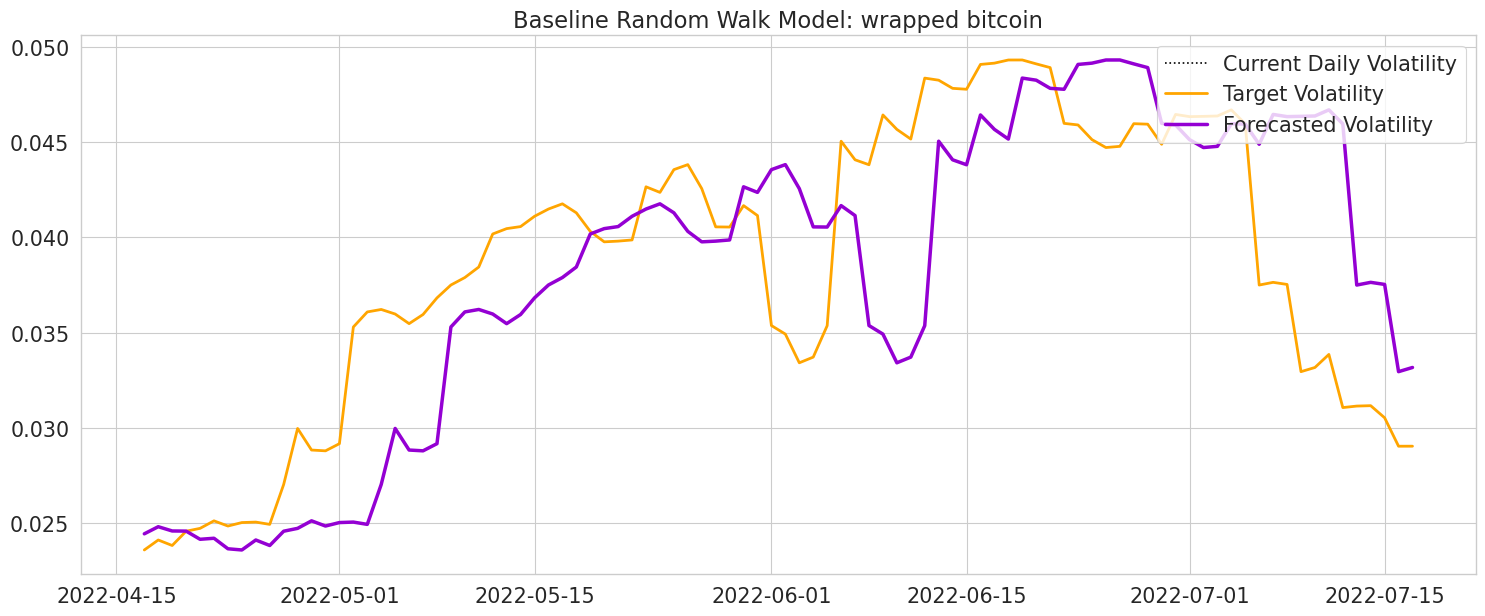

In [39]:
# Visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["baseline_random_walk_pred"],
    f'Baseline Random Walk Model: {example_token}',
)

In [40]:
# Check the model performance
pd.DataFrame(modelling_token_validation_metrics).T.sort_values(
    "baseline_random_walk_rmspe"
)

baseline_mean_rmse  baseline_mean_rmspe  \
binance usd                0.001331             1.148510   
kusama                     0.027424             0.563370   
the graph                  0.333621             6.015049   
stellar                    0.029823             0.731079   
curve dao token            0.025170             0.453475   
...                             ...                  ...   
decentraland               0.081503             0.511602   
stepn                      0.310272             0.881365   
unus sed leo               0.041423             0.363972   
usd coin                   0.004049            23.283721   
neutrino usd               0.020871             0.637791   

                 baseline_random_walk_rmse  baseline_random_walk_rmspe  
binance usd                       0.000082                    0.069090  
kusama                            0.005650                    0.095480  
the graph                         0.006171                    0.103586  
stellar                           0.005221                    0.111009  
curve dao token                   0.008582                    0.116120  
...                                    ...                         ...  
decentraland                      0.055430                    0.423077  
stepn                             0.122712                    0.440609  
unus sed leo                      0.024223                    0.644836  
usd coin                          0.000257                    0.759227  
neutrino usd                      0.013189                    1.368559  

[92 rows x 4 columns]

### 4.3.3 - GARCH Model

GARCH stands for **Generalized Autoregressive Conditional Heteroskedasticity**, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity).

GARCH includes lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.

Mathematically, GARCH can be represented as follows:

$$
\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^{p} \beta_i \sigma_{t-i}^2
$$

in which $\sigma_t^2$ is variance at time step $t$ and $\epsilon_{t-i}^2$ is the model residuals at time step $t-1$.

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is:

$$
\sigma_t^2 = \omega + \alpha \epsilon_{(t-1)}^2 + \beta \sigma_{(t-1)}^2
$$

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.

In [ ]:
for token in modelling_token_validation_results:
    # Prediction
    basic_garch_pred = garch_model(token, modelling_data_dict_full)
    modelling_token_validation_results[token]["basic_garch_pred"] = basic_garch_pred
    
    # Calculate the metrics for the baseline mean model
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}
    
    modelling_token_validation_metrics[token]["basic_garch_rmse"] = RMSE(
        target_validation, basic_garch_pred
    )
    modelling_token_validation_metrics[token]["basic_garch_rmspe"] = RMSPE(
        target_validation, basic_garch_pred
    )

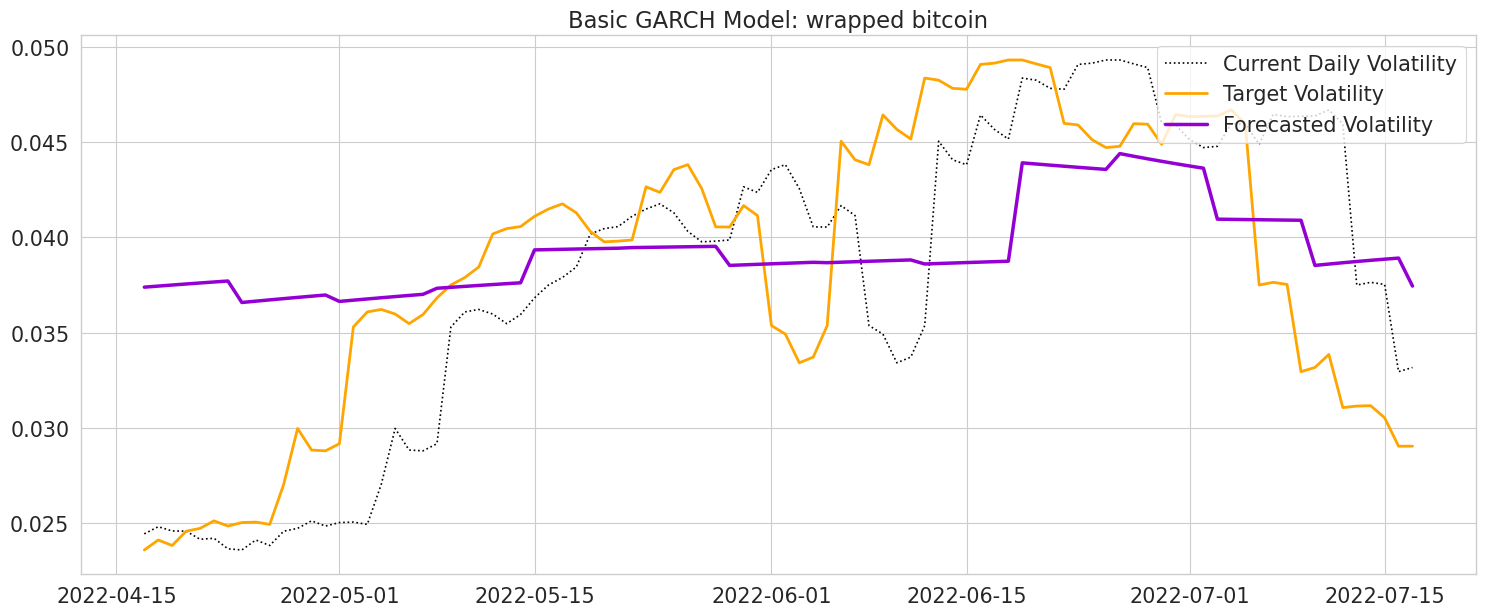

In [42]:
# visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["basic_garch_pred"],
    f'Basic GARCH Model: {example_token}',
)

In [43]:
# Check the model performance
pd.DataFrame(modelling_token_validation_metrics).T.sort_values(
    "basic_garch_rmspe"
)

baseline_mean_rmse  baseline_mean_rmspe  \
uniswap                 0.011324             0.234201   
flow                    0.010780             0.202047   
pax gold                0.003278             0.498585   
iota                    0.018983             0.330288   
1inch                   0.016690             0.345916   
...                          ...                  ...   
usd coin                0.004049            23.283721   
neutrino usd            0.020871             0.637791   
fei usd                 0.003145             0.793334   
pax dollar              0.001851             1.729827   
dai                     0.005458             4.770763   

              baseline_random_walk_rmse  baseline_random_walk_rmspe  \
uniswap                        0.007859                    0.120572   
flow                           0.010255                    0.176028   
pax gold                       0.001256                    0.153478   
iota                           0.009024                    0.148846   
1inch                          0.010404                    0.195212   
...                                 ...                         ...   
usd coin                       0.000257                    0.759227   
neutrino usd                   0.013189                    1.368559   
fei usd                        0.000709                    0.185091   
pax dollar                     0.000231                    0.134695   
dai                            0.000230                    0.193744   

              basic_garch_rmse  basic_garch_rmspe  
uniswap               0.008464           0.149318  
flow                  0.009989           0.153379  
pax gold              0.001218           0.175709  
iota                  0.010055           0.176484  
1inch                 0.010200           0.179671  
...                        ...                ...  
usd coin              0.002064          12.009549  
neutrino usd          0.063658          13.405625  
fei usd               0.218726          44.125520  
pax dollar            0.069715          80.900148  
dai                   0.388550         320.929371  

[92 rows x 6 columns]

### 4.3.4 - GJR - GARCH Model

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, financial markets often react differently to positive and negative shocks, with volatility typically increasing more after negative shocks—a phenomenon known as the leverage effect. 

The assymmetry of token reponses leads us to try differnet GARCH models. **Glosten-Jagannathan-Runkle GARCH (GJR-GARCH) model** explicitly handles this by adding an asymmetric term that accounts for the heightened impact of negative returns. 

The GJR-GARCH model is expressed as follows:

$$
\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where $I_{t-1}$ is the indicator function:

$$
I_{t-1}(\epsilon_{t-1}) =
\begin{cases} 
\epsilon_{t-1} & \text{for } \epsilon_{t-1} > 0 \\
0 & \text{otherwise}
\end{cases}
$$

Note that IGARCH requires the sum of $\alpha$ and $β$ equals 1, which implies the persistence of shocks to volatility.

In [ ]:
for token in modelling_token_validation_results:
    # Prediction
    gjr_garch_pred = garch_model(token, modelling_data_dict_full, o=1)
    modelling_token_validation_results[token]["gjr_garch_pred"] = gjr_garch_pred
    
    # Calculate the metrics for the baseline mean model
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}
    
    modelling_token_validation_metrics[token]["gjr_garch_rmse"] = RMSE(
        target_validation, gjr_garch_pred
    )
    modelling_token_validation_metrics[token]["gjr_garch_rmspe"] = RMSPE(
        target_validation, gjr_garch_pred
    )

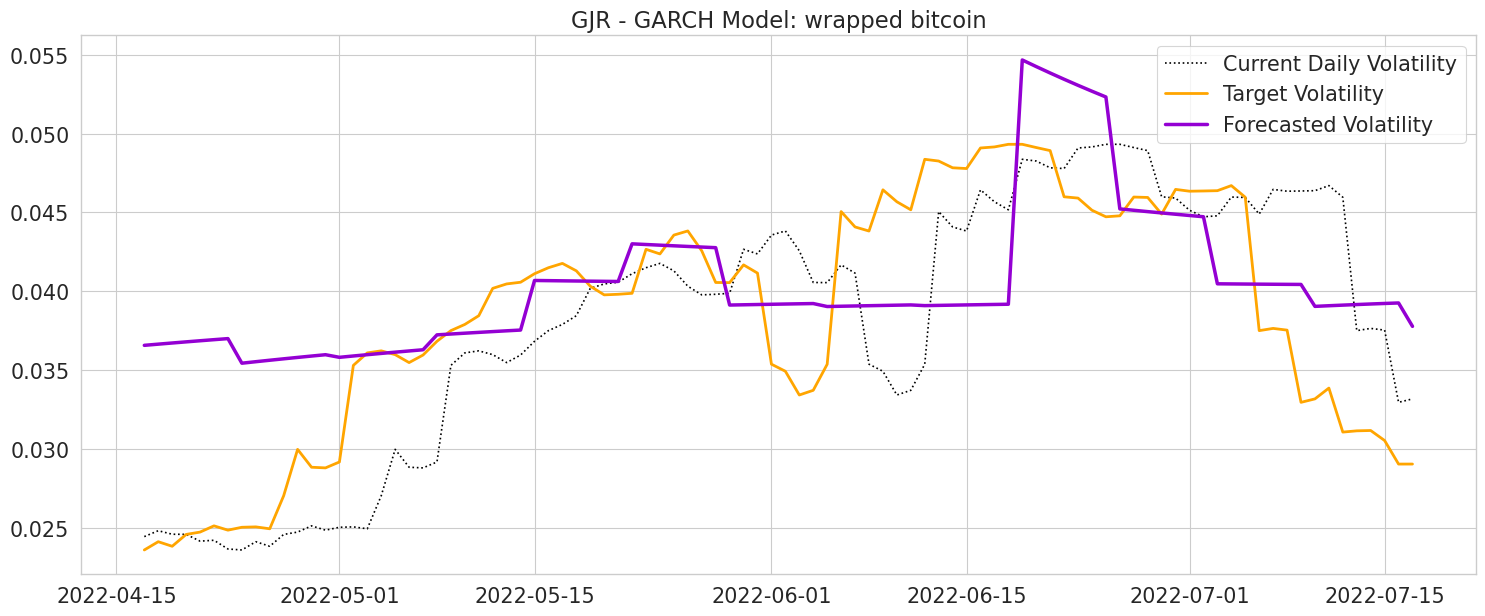

In [45]:
# visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["gjr_garch_pred"],
    f'GJR - GARCH Model: {example_token}',
)

In [46]:
# Check the model performance
pd.DataFrame(modelling_token_validation_metrics).T.sort_values(
    "gjr_garch_rmspe"
)

baseline_mean_rmse  baseline_mean_rmspe  \
lido dao                  0.027372             0.353578   
1inch                     0.016690             0.345916   
avalanche                 0.014329             0.255356   
convex finance            0.018378             0.241056   
iota                      0.018983             0.330288   
...                            ...                  ...   
tether                    0.003101            19.126922   
fei usd                   0.003145             0.793334   
neutrino usd              0.020871             0.637791   
usd coin                  0.004049            23.283721   
dai                       0.005458             4.770763   

                baseline_random_walk_rmse  baseline_random_walk_rmspe  \
lido dao                         0.012587                    0.143683   
1inch                            0.010404                    0.195212   
avalanche                        0.011645                    0.157127   
convex finance                   0.010882                    0.127336   
iota                             0.009024                    0.148846   
...                                   ...                         ...   
tether                           0.000092                    0.177846   
fei usd                          0.000709                    0.185091   
neutrino usd                     0.013189                    1.368559   
usd coin                         0.000257                    0.759227   
dai                              0.000230                    0.193744   

                basic_garch_rmse  basic_garch_rmspe  gjr_garch_rmse  \
lido dao                0.019700           0.228629        0.014822   
1inch                   0.010200           0.179671        0.008984   
avalanche               0.015585           0.190316        0.012367   
convex finance          0.014713           0.181517        0.016141   
iota                    0.010055           0.176484        0.010225   
...                          ...                ...             ...   
tether                  0.001422           8.780640        0.001318   
fei usd                 0.218726          44.125520        0.037848   
neutrino usd            0.063658          13.405625        0.142781   
usd coin                0.002064          12.009549        0.008192   
dai                     0.388550         320.929371        0.191607   

                gjr_garch_rmspe  
lido dao               0.154617  
1inch                  0.157551  
avalanche              0.159331  
convex finance         0.164272  
iota                   0.174892  
...                         ...  
tether                 8.068189  
fei usd                8.447580  
neutrino usd          31.743020  
usd coin              42.837190  
dai                  120.650976  

[92 rows x 8 columns]

### 4.3.5 - EGARCH Model

**Exponential GARCH (EGARCH) model** captures asymmetries by using a logarithmic approach without the need for non-negativity constraints on parameters.

Since EGARCH model does not support forecast horizon bigger than 1, we will predict 1 day a time

In [ ]:
for token in modelling_token_validation_results:
    # Prediction
    egarch_pred = garch_model(token, modelling_data_dict_full, vol="EGARCH", forecast_horizon=1)
    modelling_token_validation_results[token]["egarch_pred"] = egarch_pred
    
    # Calculate the metrics for the baseline mean model
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}
    
    modelling_token_validation_metrics[token]["egarch_rmse"] = RMSE(
        target_validation, egarch_pred
    )
    modelling_token_validation_metrics[token]["egarch_rmspe"] = RMSPE(
        target_validation, egarch_pred
    )

In [48]:
# visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["egarch_pred"],
    f'EGARCH Model: {example_token}',
)

In [49]:
# Check the model performance
pd.DataFrame(modelling_token_validation_metrics).T.sort_values(
    "egarch_rmspe"
)

baseline_mean_rmse  baseline_mean_rmspe  \
fei usd               0.003145             0.793334   
1inch                 0.016690             0.345916   
uniswap               0.011324             0.234201   
ftx token             0.009820             0.293431   
lido dao              0.027372             0.353578   
...                        ...                  ...   
the graph             0.333621             6.015049   
trueusd               0.003339             7.635648   
stepn                 0.310272             0.881365   
pax dollar            0.001851             1.729827   
usd coin              0.004049            23.283721   

            baseline_random_walk_rmse  baseline_random_walk_rmspe  \
fei usd                      0.000709                    0.185091   
1inch                        0.010404                    0.195212   
uniswap                      0.007859                    0.120572   
ftx token                    0.005688                    0.148608   
lido dao                     0.012587                    0.143683   
...                               ...                         ...   
the graph                    0.006171                    0.103586   
trueusd                      0.000116                    0.187992   
stepn                        0.122712                    0.440609   
pax dollar                   0.000231                    0.134695   
usd coin                     0.000257                    0.759227   

            basic_garch_rmse  basic_garch_rmspe  gjr_garch_rmse  \
fei usd             0.218726          44.125520        0.037848   
1inch               0.010200           0.179671        0.008984   
uniswap             0.008464           0.149318        0.012660   
ftx token           0.007575           0.188427        0.007620   
lido dao            0.019700           0.228629        0.014822   
...                      ...                ...             ...   
the graph           0.232331           4.191189        0.168699   
trueusd             0.001425           3.328872        0.001336   
stepn               0.147059           0.429361        0.158095   
pax dollar          0.069715          80.900148        0.000639   
usd coin            0.002064          12.009549        0.008192   

            gjr_garch_rmspe    egarch_rmse  egarch_rmspe  
fei usd            8.447580   5.016171e-04      0.131733  
1inch              0.157551   7.839121e-03      0.143311  
uniswap            0.222766   9.367300e-03      0.149984  
ftx token          0.190106   6.494853e-03      0.163046  
lido dao           0.154617   1.408524e-02      0.168568  
...                     ...            ...           ...  
the graph          2.776597  1.390325e+153           inf  
trueusd            3.116625            inf           inf  
stepn              0.466287  1.614110e+153           inf  
pax dollar         0.576788            inf           inf  
usd coin          42.837190            inf           inf  

[92 rows x 10 columns]

### 4.3.6 - TARCH Model

In [ ]:
for i in tqdm(range(len(modelling_token_validation_results))):
    token = list(modelling_token_validation_results.keys())[i]
    # Prediction
    tarch_pred = garch_model(
        token,
        modelling_data_dict_full,
        p=1,
        q=1,
        o=1,
        power=1,
        dist="skewt",
        forecast_horizon=1,
    )
    modelling_token_validation_results[token]["tarch_pred"] = tarch_pred

    # Calculate the metrics for the baseline mean model
    target_validation = modelling_token_validation_results[token]["target_validation"]
    if token not in modelling_token_validation_metrics:
        modelling_token_validation_metrics[token] = {}

    modelling_token_validation_metrics[token]["tarch_rmse"] = RMSE(
        target_validation, tarch_pred
    )
    modelling_token_validation_metrics[token]["tarch_rmspe"] = RMSPE(
        target_validation, tarch_pred
    )

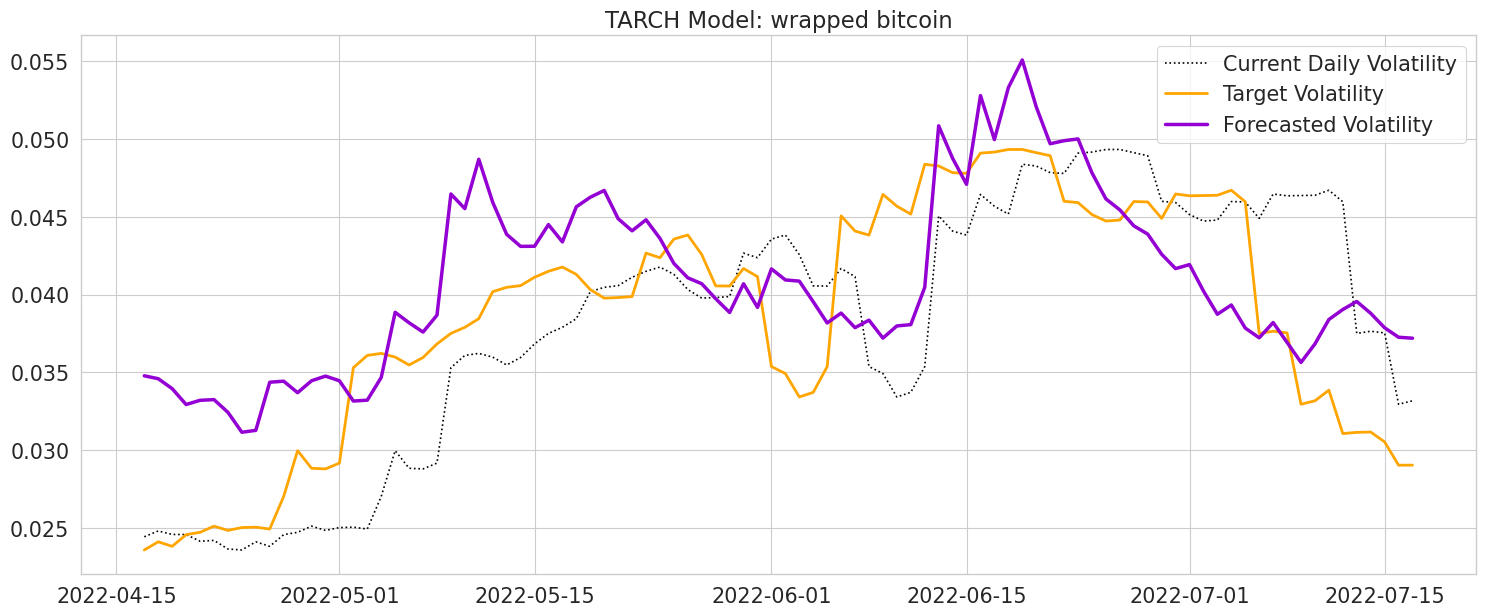

In [51]:
# visualize the results
plot_model_prediction(
    modelling_token_validation_results[example_token]["vol_validation"],
    modelling_token_validation_results[example_token]["target_validation"],
    modelling_token_validation_results[example_token]["tarch_pred"],
    f'TARCH Model: {example_token}',
)

## 4.4 - Prediction

For each token, we select the model that works the best for its condition, and then predict on the test sample using the method that works the best.

### 4.4.1 - Check the best model for each token

In [52]:
result_comparison_df = pd.DataFrame(modelling_token_validation_metrics).T
result_comparison_df["best_model_rmse"] = result_comparison_df[
    [
        "baseline_mean_rmse",
        "baseline_random_walk_rmse",
        "basic_garch_rmse",
        "gjr_garch_rmse",
        "egarch_rmse",
        "tarch_rmse",
    ]
].idxmin(axis=1)
result_comparison_df["best_model_rmse"] = result_comparison_df["best_model_rmse"].apply(
    lambda x: x.split("_rmse")[0]
)

In [53]:
result_comparison_df['best_model_rmse'].value_counts()

baseline_random_walk    79
egarch                   5
tarch                    5
basic_garch              2
gjr_garch                1
Name: best_model_rmse, dtype: int64

In [54]:
result_comparison_df["best_model_rmspe"] = result_comparison_df[
    [
        "baseline_mean_rmspe",
        "baseline_random_walk_rmspe",
        "basic_garch_rmspe",
        "gjr_garch_rmspe",
        "egarch_rmspe",
        "tarch_rmspe",
    ]
].idxmin(axis=1)
result_comparison_df["best_model_rmspe"] = result_comparison_df[
    "best_model_rmspe"
].apply(lambda x: x.split("_rmspe")[0])

In [55]:
result_comparison_df['best_model_rmspe'].value_counts()

baseline_random_walk    74
tarch                    8
egarch                   5
basic_garch              3
baseline_mean            1
gjr_garch                1
Name: best_model_rmspe, dtype: int64

Surprisingly, we found that the baseline random walk model worked out the best for most tokens, possibly due to the fact that cryptocurrency markets are highly unpredictable and the pattern is hard to be captured using relatively simple time-series models.

### 4.4.2 - Get prediction on test set for each token

We mainly relied on RMSPE to select the best model and make prediction on the testing set. 

In [ ]:
for index, row in result_comparison_df.iterrows():
    token_name = index
    best_model_rmspe = row['best_model_rmspe']
    
    test_pred_rmspe = get_best_pred(token_name, modelling_data_dict_full, best_model_rmspe)
    modelling_data_dict_full[token_name]['vol_test_pred'] = test_pred_rmspe

In [58]:
# Check the results
example_token = 'wrapped bitcoin'
plot_model_prediction(
    modelling_data_dict_full[example_token]["vol_test"],
    modelling_data_dict_full[example_token]["target_test"],
    modelling_data_dict_full[example_token]["vol_test_pred"],
    f'Best Model on Testing: {example_token}',
)

# PART 5: Next Step

I believe there is potential to apply more complex models, such as LSTM, for forecasting volatility, and I would like to explore this option in the future.

In addition, it's well known that economic events can affect market dynamics. Incorporating regular economic calendar events or significant events that could influence Bitcoin movements into models may further improve predictive power.